# Define Forecasting
Forecasting is a technique that uses historical data as inputs to make informed estimates that are predictive in determining the direction of future trends. It's a planning tool that helps management in its attempts to cope with the uncertainty of the future, relying mainly on data from the past and present and analysis of trends. Forecasting is used in various areas such as weather prediction, sales projection, stock market trends, and many more. In the context of time series data, forecasting is often associated with making predictions about the future based on time-dependent data.

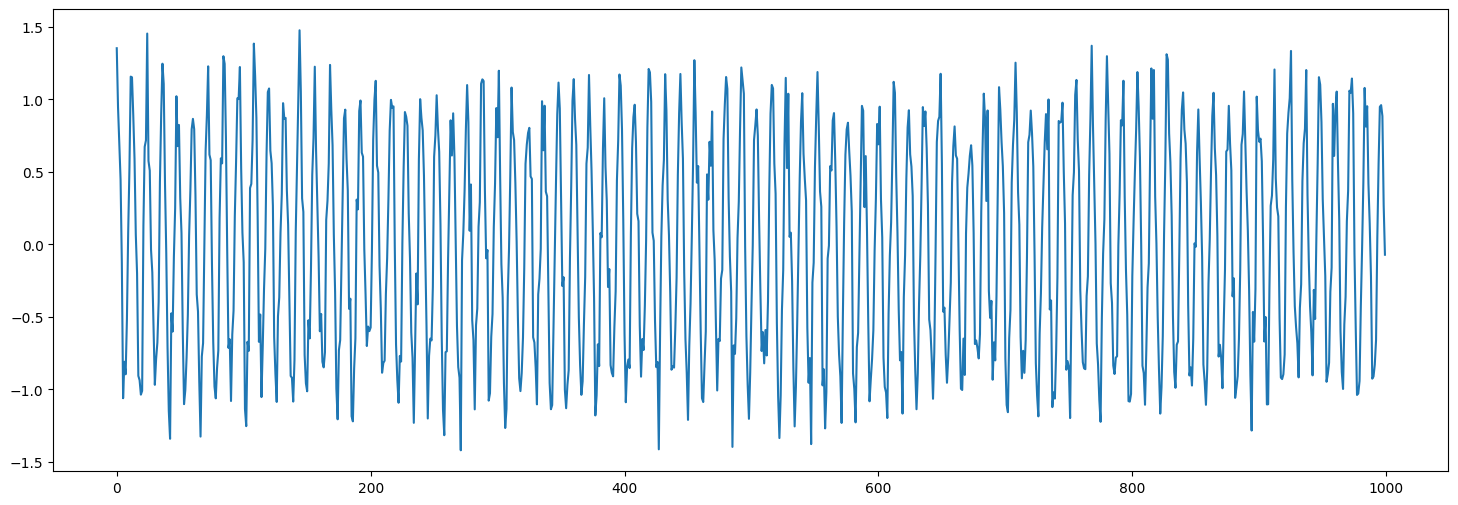

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Set the random seed for reproducibility
np.random.seed(0)

# Define the parameters
n_samples = 1000  # Number of samples in the time series
seasonality_period = 12  # Period of the cosine seasonality
noise_std = 0.2  # Standard deviation of the noise

# Generate the time index
t = np.arange(n_samples)

# Generate the cosine seasonality component
seasonality = np.cos(2 * np.pi * t / seasonality_period)

# Generate the noise component
noise = np.random.normal(0, noise_std, n_samples)

# Combine the components to create the synthetic time series
time_series = seasonality + noise

# Plot the synthetic time series
plt.figure(figsize=(18,6))
plt.plot(time_series)
plt.show()

In [2]:
# Define the train-test split ratio
train_ratio = 0.8

# Calculate the index to split the time series
split_index = int(len(time_series) * train_ratio)

# Split the time series into train and test sets
train_set = time_series[:split_index]
test_set = time_series[split_index:]

# Print the train and test sets
print("Train set:", train_set[:10])
print("Test set:", test_set[:10])


Train set: [ 1.35281047  0.94605685  0.6957476   0.44817864 -0.1264884  -1.06148098
 -0.80998232 -0.89629685 -0.52064377  0.0821197 ]
Test set: [-0.21776559  0.15716077  0.4885061   0.78778199  1.18818352  0.94706622
  0.59961048 -0.00523845 -0.83764601 -0.8885186 ]


# Global Variables

In [3]:
import pandas as pd
train_df = pd.DataFrame(train_set, columns=["value"])
test_df = pd.DataFrame(test_set, columns=["value"])
print(train_df)

        value
0    1.352810
1    0.946057
2    0.695748
3    0.448179
4   -0.126488
..        ...
795 -0.179788
796 -0.485083
797 -1.081445
798 -1.084933
799 -1.032018

[800 rows x 1 columns]


In [4]:
import numpy as np
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

def plot_and_validate(train, test, predictions):
    if len(test.columns) > 1:
        for i, column in enumerate(test.columns):
            rmse = np.sqrt(mean_squared_error(test[column], predictions[:, i]))
            print(f"Test RMSE for {column}: {rmse:.3f}")
    else:
        rmse = np.sqrt(mean_squared_error(test.values, predictions))
        print(f"Test RMSE: {rmse:.3f}")
        
    plt.figure(figsize=(18,6))
    # Plot train set
    plt.plot(train, label='Train Set')

    # Plot test set
    test_x = np.arange(len(train), len(train)+len(test))
    plt.plot(test_x, test, label='Test Set')
    plt.plot(test_x, predictions, label='Predictions')

    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.title('Predictions vs Ground Truth')
    plt.legend()
    plt.show()

# Persistence Demonstration

Test RMSE: 1.285
Test RMSE: 1.285


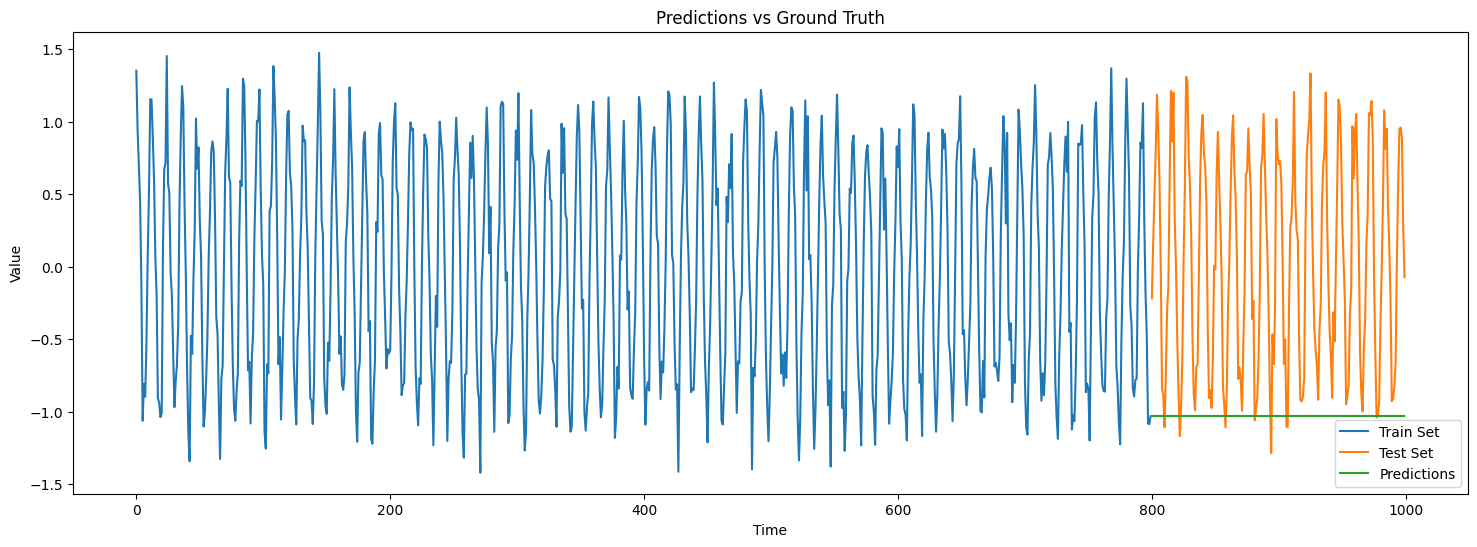

In [5]:
import pandas as pd
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

predictions = [train_df.values[-1]]*len(test_set)
rmse = np.sqrt(mean_squared_error(test_df.values, predictions))
print('Test RMSE: %.3f' % rmse)

# Plot train set
plot_and_validate(train_df, test_df, predictions)

# Simple Moving Average Demonstration
Demonstrate the use of Simple Moving Average in time series forecasting.

Test RMSE: 0.747


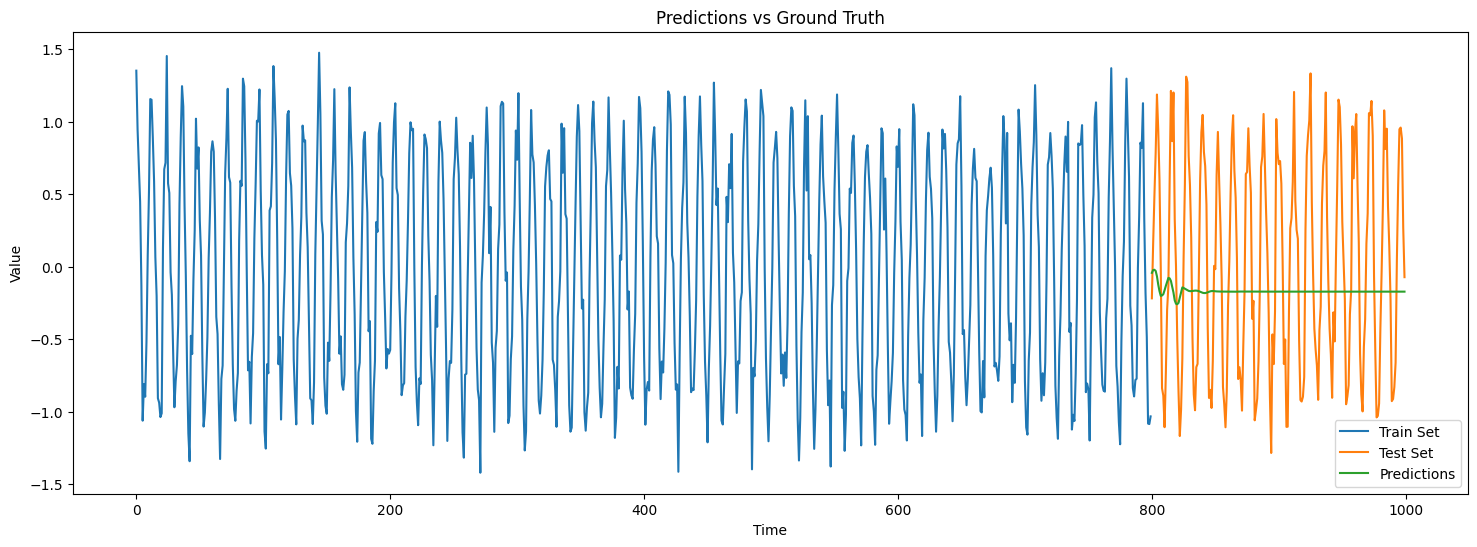

In [6]:
# Import additional required library
import numpy as np

# Simple Moving Average model
def model_sma(history, window_size):
    return np.mean(history[-window_size:])

# Walk-forward validation for SMA
predictions_sma = list()
history = train_df['value'].values.tolist()

for i in range(len(test_df)):
    # Predict and append to predictions
    yhat = model_sma(history, 24)
    predictions_sma.append(yhat)
    
    # Add actual observation to history for the next loop
    history.append(yhat)

plot_and_validate(train_df, test_df, predictions_sma)

# Exponential Smoothing Demonstration
Demonstrate the use of Exponential Smoothing in time series forecasting.

Test RMSE: 0.771


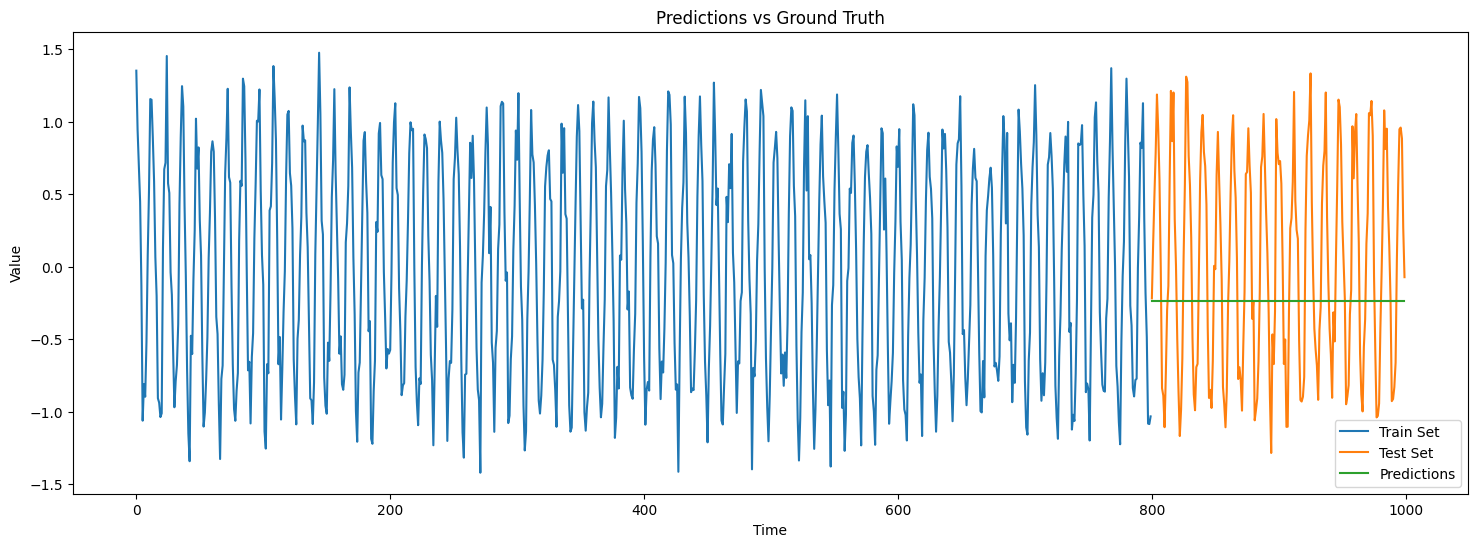

In [7]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from numpy import sqrt

# Fit the model
model = SimpleExpSmoothing(train_df['value'])
model_fit = model.fit(smoothing_level=0.1, optimized=False)

# Make prediction
yhat = model_fit.forecast(len(test_df))

# Walk-forward validation for Exponential Smoothing
predictions_exp = list()
history = train_df['value'].values.tolist()

for i in range(len(test_df)):
    # Predict and append to predictions
    yhat = model_fit.predict(len(history), len(history))
    predictions_exp.append(yhat)
    
    # Add actual observation to history for the next loop
    history.append(test_df['value'].values[i])

plot_and_validate(train_df, test_df, predictions_exp)

# ARIMA and SARIMA Demonstration
Demonstrate the use of ARIMA and SARIMA models in time series forecasting.

/home/javier/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/javier/.local/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Test RMSE: 0.232


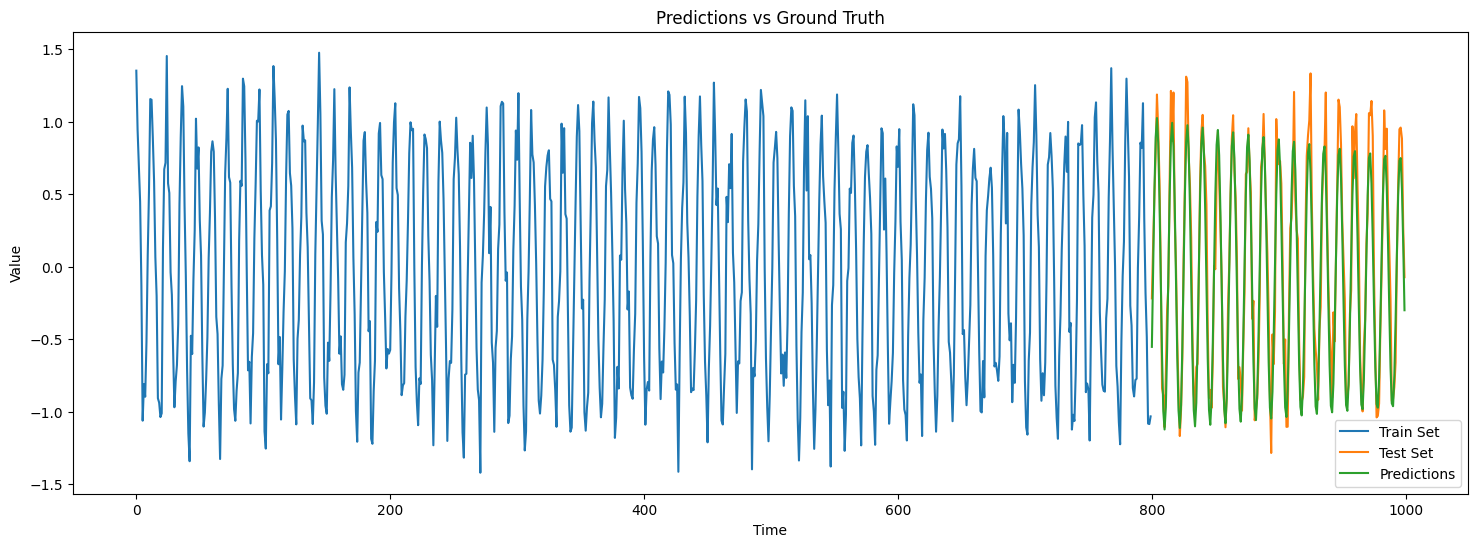

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.93088D-02    |proj g|=  9.28780D-01

At iterate    5    f= -1.81570D-03    |proj g|=  2.62122D-03


 This problem is unconstrained.



At iterate   10    f= -1.82037D-03    |proj g|=  1.90269D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     14     18      1     0     0   5.742D-05  -1.821D-03
  F =  -1.8206842137482226E-003

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Test RMSE: 0.236


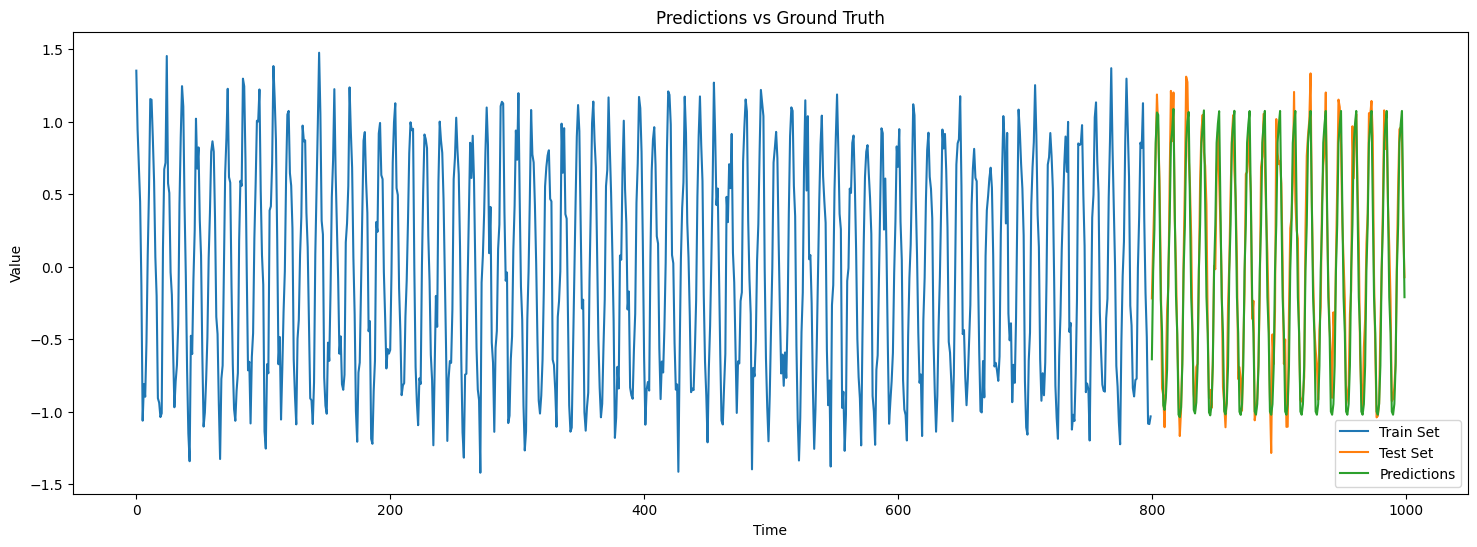

In [8]:
# Import the required libraries
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

# ARIMA model
model_arima = ARIMA(train_df['value'], order=(3,2,10))
model_arima_fit = model_arima.fit()

# Make predictions
predictions_arima = model_arima_fit.predict(start=len(train_df), end=len(train_df) + len(test_df) - 1)
plot_and_validate(train_df, test_df, predictions_arima)

# SARIMA model
model_sarima = SARIMAX(train_df['value'], order=(1,0,1), seasonal_order=(1, 1, 0, 12))
model_sarima_fit = model_sarima.fit()

# Make predictions
predictions_sarima = model_sarima_fit.predict(start=len(train_df), end=len(train_df) + len(test_df) - 1)
plot_and_validate(train_df, test_df, predictions_sarima)


# Prophet Demonstration
Demonstrate the use of Prophet in time series forecasting.

/home/javier/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.
15:02:35 - cmdstanpy - INFO - Chain [1] start processing
15:02:35 - cmdstanpy - INFO - Chain [1] done processing


Test RMSE: 0.225


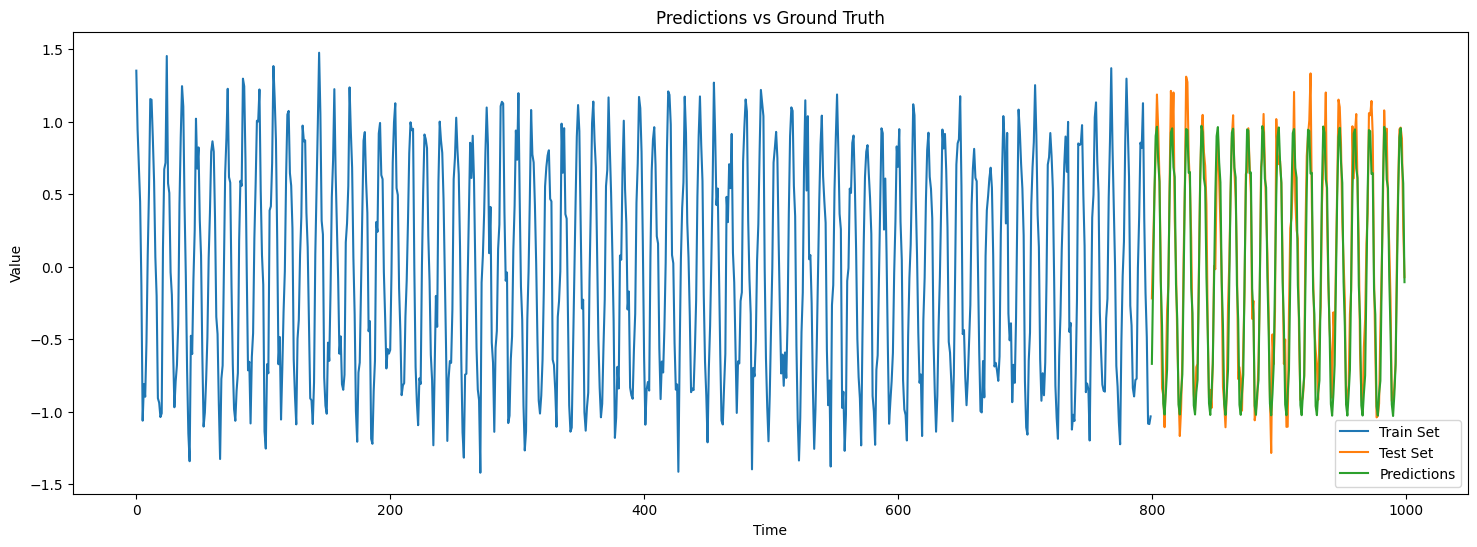

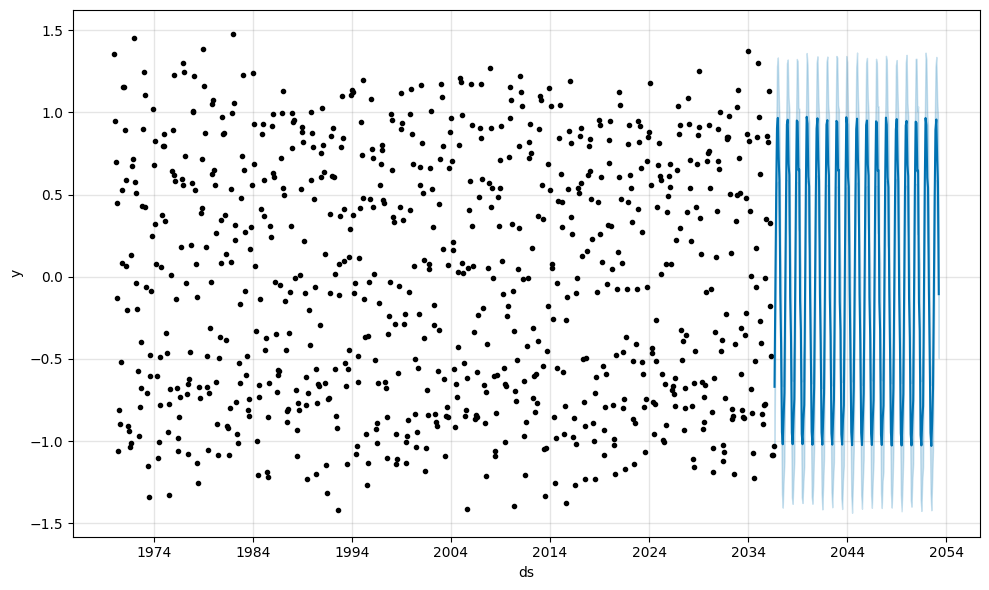

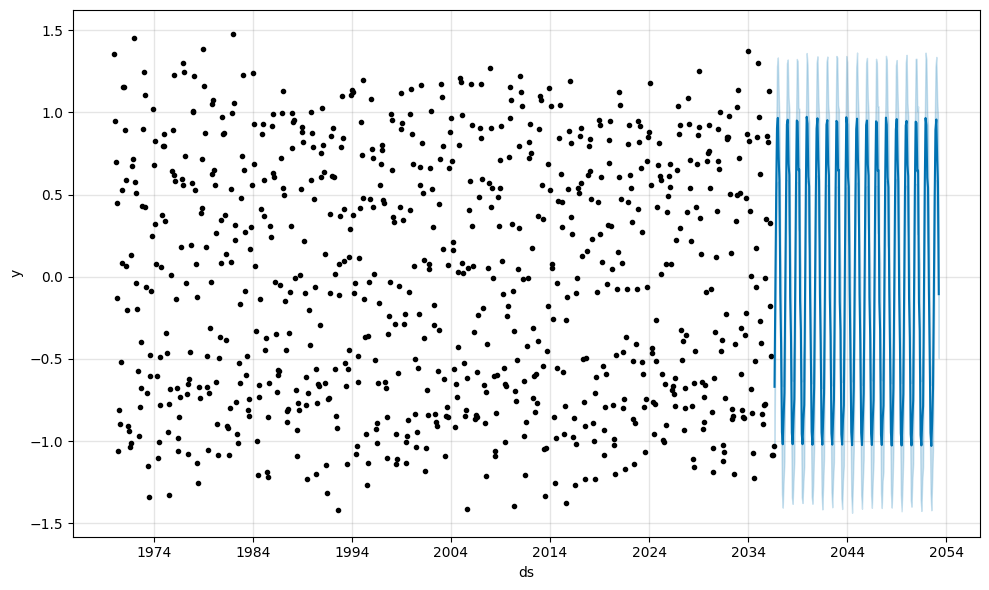

In [9]:
# Import the required library
from prophet import Prophet

# Initialize the Model
model_prophet = Prophet(interval_width=0.95)
new_df = train_df.reset_index().rename(columns={'index':'ds', 'value':'y'})
new_df['ds'] = pd.to_datetime(new_df['ds'], unit='M')

# Fit the Model
model_prophet.fit(new_df)

# Make Future Dataframe
future = model_prophet.make_future_dataframe(periods=len(test_df), freq='M', include_history=False)

# Make Predictions
forecast = model_prophet.predict(future)

# Extract Predicted Values
predictions_prophet = forecast['yhat'].values[-len(test_df):]

# Calculate RMSE for Prophet
rmse_prophet = sqrt(mean_squared_error(test_df, predictions_prophet))
plot_and_validate(train_df, test_df, predictions_prophet)

# Use the plot with confidence intervals
model_prophet.plot(forecast)


# Vector Autoregression Demonstration
VAR is used for multivariate time series, we define a second new variable to perform forecasting on the first one.

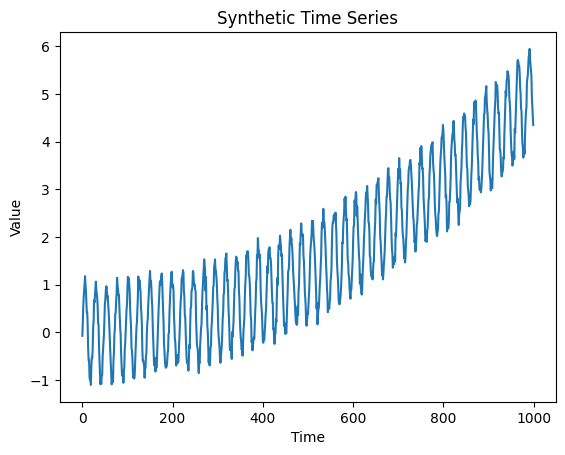

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# Set the parameters
trend_coeff = 5e-6
seasonality_period = 24
noise_std = 0.1
n_samples = 1000

# Generate the time index
t = np.arange(n_samples)

# Generate the quadratic ascending trend
trend = trend_coeff * t**2

# Generate the sine seasonality
seasonality = np.sin(2* np.pi * t / seasonality_period)

# Generate the random noise
noise = np.random.normal(0, noise_std, n_samples)

# Generate the synthetic time series
time_series = trend + seasonality + noise

# Assuming your synthetic time series is stored in the variable 'data'
plt.plot(time_series)
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Synthetic Time Series')
plt.show()

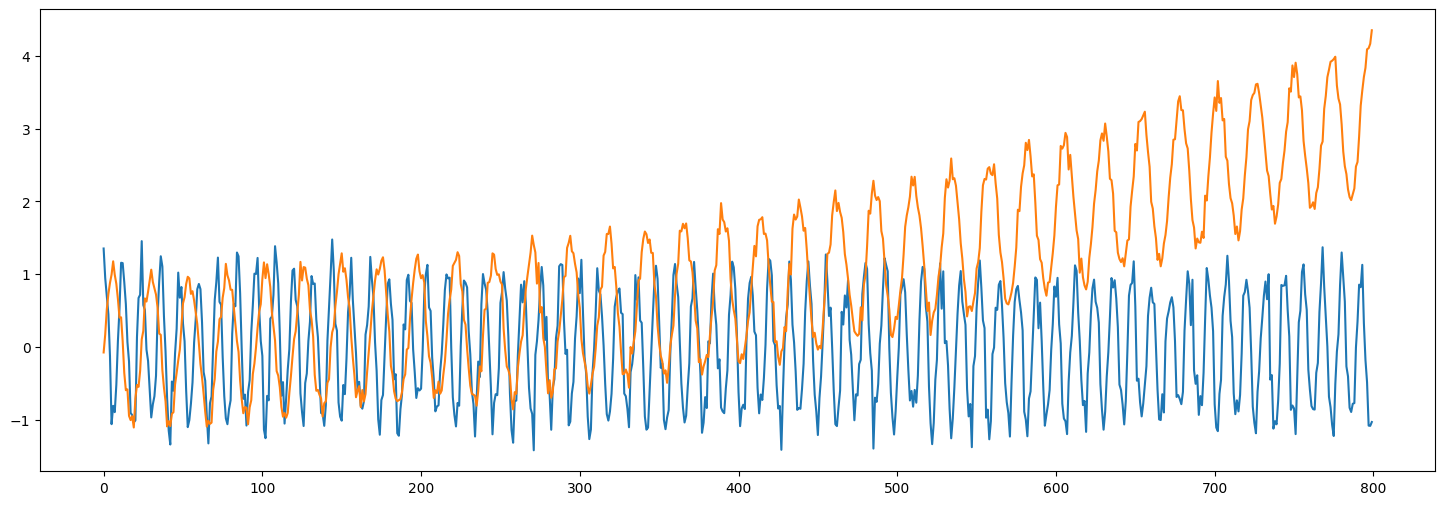

In [11]:
train_set = time_series[:split_index]
test_set = time_series[split_index:]

train_df['aux_value'] = train_set
test_df['aux_value'] = test_set

# Plot the synthetic multi-variate time series

plt.figure(figsize=(18,6))
plt.plot(train_df['value'], label='Main variable')
plt.plot(train_df['aux_value'], label='Secondary variable')
plt.show()


Test RMSE for value: 0.223
Test RMSE for aux_value: 0.796


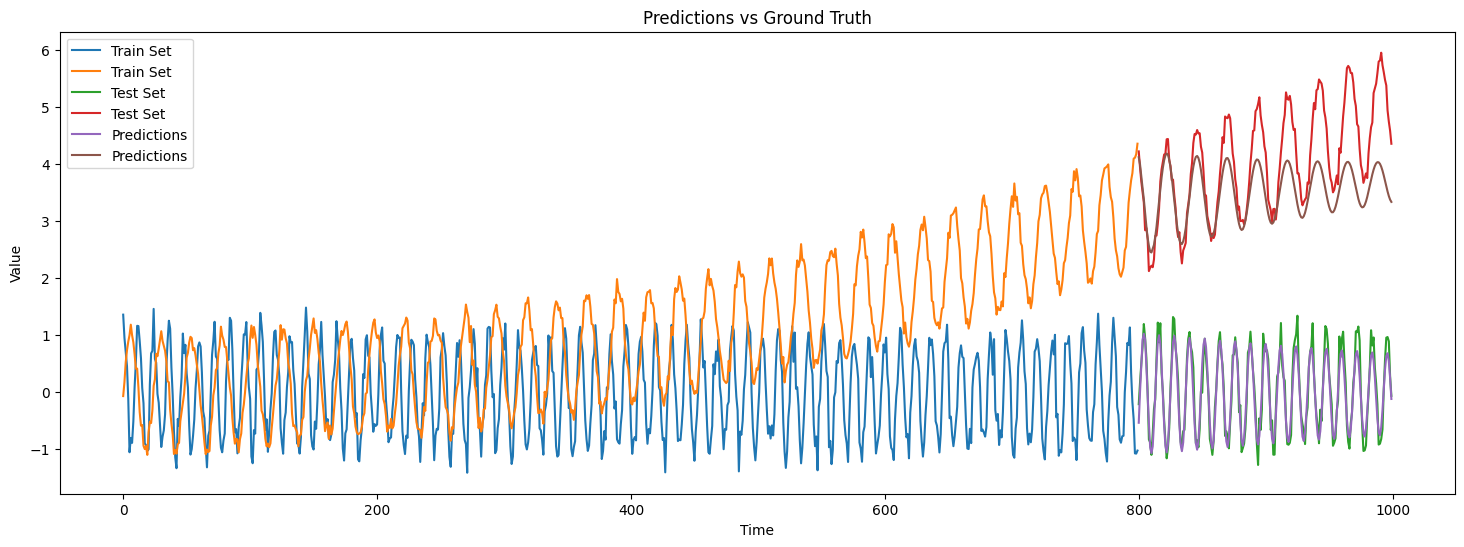

In [12]:
# Import the required libraries
from statsmodels.tsa.vector_ar.var_model import VAR
from sklearn.preprocessing import StandardScaler


# Normalize features to a range
scaler = StandardScaler()
train_scaled = scaler.fit_transform(train_df.values)
test_scaled = scaler.transform(test_df.values)

# Convert to DataFrame
train_scaled = pd.DataFrame(train_scaled, columns=train_df.columns)
test_scaled = pd.DataFrame(test_scaled, columns=test_df.columns)

# Fit the model
model = VAR(endog=train_scaled)
model_fit = model.fit(maxlags=12) # maxlags is the maximum number of lags to consider, use 24 to fix the issue

# Make prediction
prediction = model_fit.forecast(model_fit.endog, steps=len(test_df))

# Invert transformation
prediction = scaler.inverse_transform(prediction)
plot_and_validate(train_df, test_df, prediction)


# Random Forest Demonstration
Any ML regressor can be used to forecast

Test RMSE for value: 0.509
Test RMSE for aux_value: 0.997


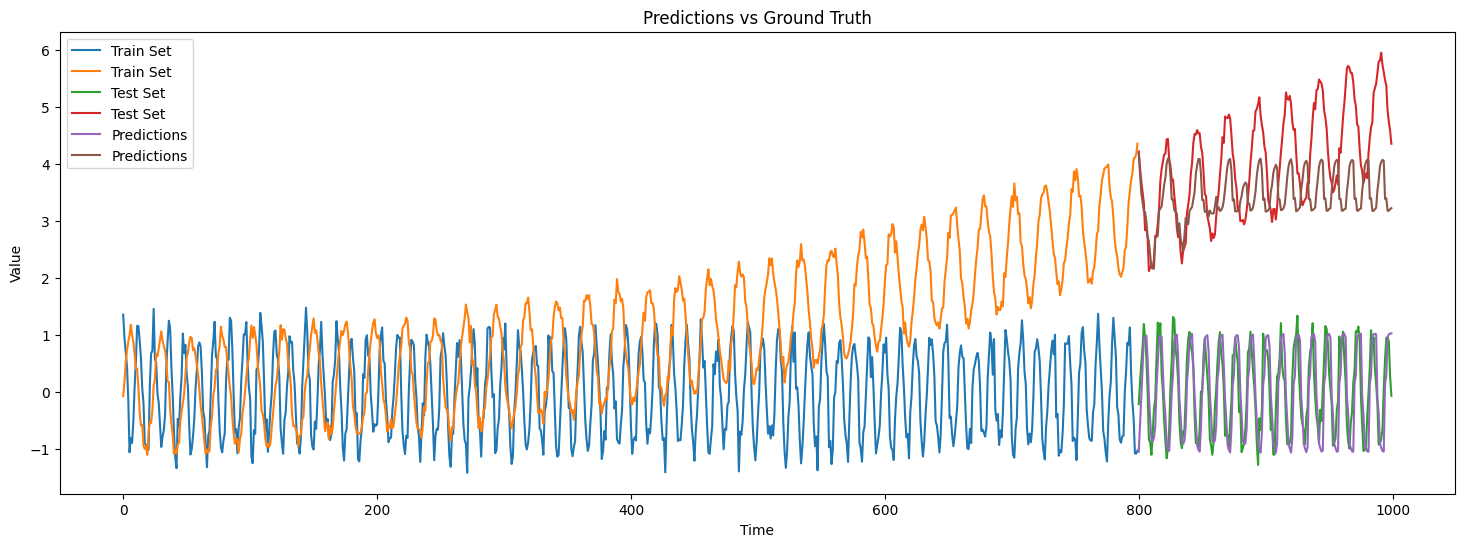

In [13]:
from sklearn.ensemble import RandomForestRegressor

# Define the model
model_rf = RandomForestRegressor(n_estimators=500, random_state=0)

sliding_window = 48
# Prepare train data
slide_train_df = pd.DataFrame()
for i in range(sliding_window+1):
    for column in train_df.columns:
        slide_train_df[f'{column}-{i}'] = train_scaled[column].shift(i)

slide_train_df.dropna(inplace=True)
slide_train_df_shuffled = slide_train_df.sample(frac=1, random_state=0)
slide_train_df_x = slide_train_df_shuffled.iloc[:,2:]
slide_train_df_y = slide_train_df_shuffled.iloc[:,:2]

# Fit the model
model_rf.fit(slide_train_df_x.values, slide_train_df_y.values)

# Generate predictions
test_inputs = slide_train_df.iloc[-1, 2:].values.reshape(1, -1)
prediction_rf = []
for i in range(len(test_df)):
    prediction = model_rf.predict(test_inputs)
    prediction_rf.append(prediction)
    test_inputs = np.roll(test_inputs, 2)
    test_inputs[0, :2] = prediction

prediction_rf = scaler.inverse_transform(np.array(prediction_rf).reshape(-1, 2))
plot_and_validate(train_df, test_df, prediction_rf)


# LSTM Model Demonstration
Demonstrate the use of LSTM model (with PyTorch) in time series forecasting.

In [18]:
# Import the required libraries
import torch
import torch.nn as nn
from tqdm.auto import tqdm
import random
from sklearn.metrics import mean_squared_error

# Define LSTM model
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size
        self.lstm = nn.LSTM(input_size, hidden_layer_size)
        self.linear = nn.Linear(hidden_layer_size, output_size)
        self.reset_hidden_cell()

    def reset_hidden_cell(self):
        self.hidden_cell = (torch.zeros(1,self.hidden_layer_size),
                            torch.zeros(1,self.hidden_layer_size))
        
    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq, self.hidden_cell)
        return self.linear(lstm_out)

# Prepare data for LSTM
train_data_normalized = torch.FloatTensor(train_scaled.values).view(-1, 2)

# Define a method to create in-out sequences
def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw-1]
        train_label = input_data[i+1:i+tw]
        inout_seq.append((train_seq ,train_label))
    return inout_seq


# Create in-out sequences
window_size = 12
train_inout_seq = create_inout_sequences(train_data_normalized, window_size)

# Initialize the model, define loss and optimization functions
model = LSTM(input_size=2, hidden_layer_size=50, output_size=2)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Train the model
epochs = 100
for i in range(epochs):
    epoch_loss = 0
    rmse = 0
    random.shuffle(train_inout_seq) # Randomize the training data
    for seq, labels in train_inout_seq:
        optimizer.zero_grad()
        model.reset_hidden_cell()
        y_pred = model(seq)

        single_loss = loss_function(y_pred.squeeze(), labels)
        single_loss.backward()
        optimizer.step()
        
        with torch.no_grad():
            epoch_loss += single_loss/len(train_inout_seq)
            rmse += np.sqrt(mean_squared_error(scaler.inverse_transform(labels.detach().numpy()), 
                                              scaler.inverse_transform(y_pred.squeeze().detach().numpy()))
                         )/len(train_inout_seq)

    print(f'Epoch {i} loss: {epoch_loss}. RMSE: {rmse}', end='\r')
    

100%|██████████| 200/200 [00:00<00:00, 3639.12it/s]

Test RMSE for value: 0.985
Test RMSE for aux_value: 2.039


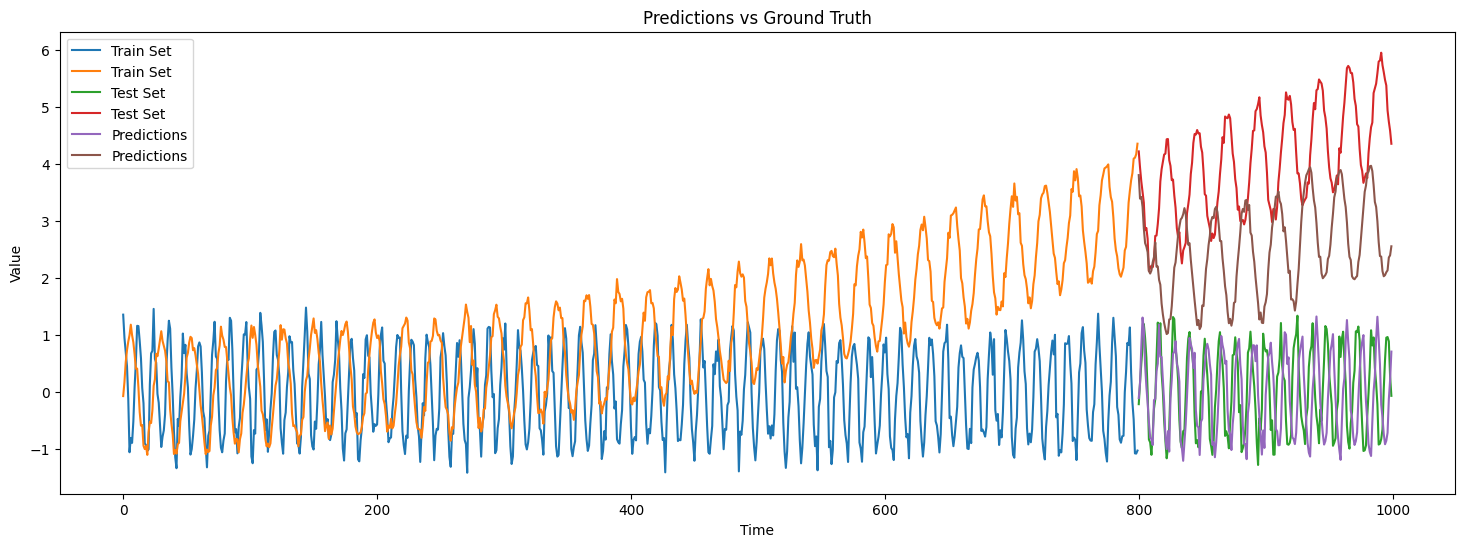

In [19]:
# Evaluation
fut_pred = len(test_scaled)
test_inputs = train_data_normalized[-window_size:].tolist()
predictions = []
model.eval()
with torch.no_grad():
    model.reset_hidden_cell()
    seq = torch.FloatTensor(test_inputs[-window_size:])
    output = model(seq)[-1].unsqueeze(0)
    test_inputs.append(output.numpy())

    for i in tqdm(range(fut_pred)):
        output = model(output)
        test_inputs.append(output[-1].numpy())

# Invert transformations
actual_predictions = scaler.inverse_transform(np.array(test_inputs[-fut_pred:]).reshape(-1, 2))

# Calculate RMSE for LSTM
plot_and_validate(train_df, test_df, actual_predictions)
